In [1]:
from twarc_csv import DataFrameConverter
from twarc.expansions import ensure_flattened
import pandas as pd
from twarc_csv import dataframe_converter
from twarc_csv import CSVConverter, DataFrameConverter
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import numpy as np
import pickle
import json
import random

**Manual Input**: Set the path.

In [2]:
path='C:/Users/acoub/OneDrive/Desktop/DSDM/Thesis/ChileGov/methodology_feminism'
sep='/'

In [3]:
path_scripts = path+sep+'update_existing'
path_data= path+sep+'data'

In [4]:
converter = DataFrameConverter()
data = []
with open(path_data+sep+"up_right_left_hashtags.json") as f:
    for line in f:
        data.append(json.loads(line))
df = converter.process(data)

In [5]:
authors=list(df['author.username'])
authors = list(set(authors))
print(len(authors))

192


In [6]:
def hash_retrieve(df):
    """
    df : dataframe of tweets
    Description: 
        The function takes as an object a df of tweets obtained via twarc and 
        returns a generator object.
    
    """

    for line, id in zip(df['entities.hashtags'], df['id']):
        if pd.isna(line):
            continue
        line = line.strip()
        data = json.loads(line)
        for hashtag in ensure_flattened(data):
            yield [hashtag['tag'], id]

In [7]:
hashtags_df = pd.DataFrame(list(hash_retrieve(df)),
                 columns=['tweet_hashtags', 'id'])

hashtags_df = hashtags_df.groupby('id')['tweet_hashtags'].apply(lambda x: ','.join(x))
df = df.merge(hashtags_df, how='left', left_on='id', right_on='id')
df['tweet_hashtags']=df['tweet_hashtags'].str.lower()

hasht=[]
for i in df.index:
    try:
        hasht.append(df['tweet_hashtags'][i].split(","))
    except:
        hasht.append([])
    
    
df['list_hashtags']=hasht

hashtags=[]
for i in df.index:
    hashtags+=list(df['list_hashtags'][i])

In [8]:
from collections import Counter
count = Counter(hashtags)
  
most_occur = count.most_common(100)
  
print(most_occur)

[('kastpresidente2022', 4566), ('boricpresidente', 2250), ('chilevotakast', 1648), ('kastledaesperanzaachile', 1623), ('atreveteconkast', 1609), ('kastpresidente', 1058), ('todochileconkast', 1057), ('boricpresidentedechile', 834), ('boricpresidente2022', 829), ('vota2votakast', 730), ('mujeresporkast', 669), ('boricpresidentedechile2022', 546), ('seguimos', 503), ('debateanatel', 494), ('atreveteporchile', 420), ('kast', 394), ('kastenprimeravuelta', 378), ('chile', 355), ('todochilevotakast', 351), ('boricnosune', 340), ('votakast', 308), ('lascarasdelamoneda', 307), ('atrevidos', 291), ('debatepresidencial2021', 271), ('boricenprimeravuelta', 259), ('meunoconboric', 249), ('boric', 246), ('elecciones2021cl', 236), ('ahorayasna', 236), ('kastlalleva', 214), ('kastesperanzaparachile', 203), ('sichelpresidente', 199), ('kast2022', 196), ('boricmiente', 192), ('sepuede', 190), ('borichambreymiseriaparachile', 188), ('fiestadelosatrevidos', 185), ('atrevidosporkast', 183), ('rutaesperanz

### Count the number of left and right hashtgas per user

In [9]:
file = path_data+sep+'left_hashtags_for_label.sav'
left_hashtags = pickle.load(open(file, 'rb'))

file = path_data+sep+'right_hashtags_for_label.sav'
right_hashtags = pickle.load(open(file, 'rb'))

In [10]:
# For each left hashtags we put a 1 to each tweet that use this hashtag
for hashtag in left_hashtags:
    df_hash=pd.DataFrame()
    df_hash=df.dropna(subset=['tweet_hashtags']).copy()
    df_hash=df_hash[df_hash.tweet_hashtags.str.contains(hashtag)]
    df_hash['count_left_'+str(hashtag)]=1
    df=df.merge(df_hash[['id','count_left_'+str(hashtag)]],how="left",on="id")

In [11]:
# We sum for all the hashtags.
df['count_left']=0
for hashtag in left_hashtags:
    try:
        df[['count_left_'+str(hashtag)]]=df[['count_left_'+str(hashtag)]].fillna(0)
        df['count_left']+=df['count_left_'+str(hashtag)]
    except:
        print("No use of hashtag: " + hashtag)

In [12]:
# Doing the same for right hashtags
for hashtag in right_hashtags:
    df_hash=pd.DataFrame()
    df_hash=df.dropna(subset=['tweet_hashtags']).copy()
    df_hash=df_hash[df_hash.tweet_hashtags.str.contains(hashtag)]
    df_hash['count_right_'+str(hashtag)]=1
    df=df.merge(df_hash[['id','count_right_'+str(hashtag)]],how="left",on="id")

In [13]:
df['count_right']=0
for hashtag in right_hashtags:
    try:
        df[['count_right_'+str(hashtag)]]=df[['count_right_'+str(hashtag)]].fillna(0)
        df['count_right']+=df['count_right_'+str(hashtag)]
    except:
        print("No use of hashtag: " + hashtag)

In [14]:
# Now we group by author, to know all the hashtags that each user used.
hashtags_per_author=df[['author.username','count_right','count_left']].groupby('author.username').sum()

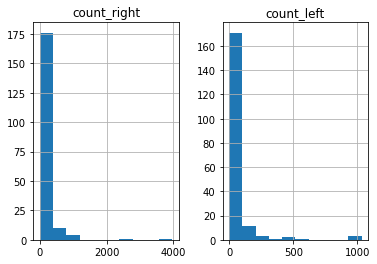

In [15]:
hashtags_per_author.hist();

### Labeling users

In [16]:
# We compute the % of right and left hashtags per user
hashtags_per_author['percentage_right']=hashtags_per_author['count_right'].astype(float)/(hashtags_per_author['count_right'].astype(float)+hashtags_per_author['count_left'].astype(float))
hashtags_per_author['percentage_left']=hashtags_per_author['count_left'].astype(float)/(hashtags_per_author['count_right'].astype(float)+hashtags_per_author['count_left'].astype(float))

To label user we define thresholds. More than 40 hashtags for the affiliation and also over 80% of hashtags of this affiliation.
  
**Manual input:** You can change this threshold depending on how strict do you want to be with the criterium. Higher threshold produce less authors with labels, but more sure that the labels are correct. The proportion have to be higher than 0.5.

In [17]:
number_threshold=40
proportion_threshold=0.8

In [18]:
hashtags_per_author['Label']="None"
hashtags_per_author['Label'][(hashtags_per_author.percentage_right>proportion_threshold)&(hashtags_per_author.count_right>number_threshold)]="Right"
hashtags_per_author['Label'][(hashtags_per_author.percentage_left>proportion_threshold)&(hashtags_per_author.count_left>number_threshold)]="Left"

<ipython-input-18-70f4d096c652>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hashtags_per_author['Label'][(hashtags_per_author.percentage_right>proportion_threshold)&(hashtags_per_author.count_right>number_threshold)]="Right"
<ipython-input-18-70f4d096c652>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hashtags_per_author['Label'][(hashtags_per_author.percentage_left>proportion_threshold)&(hashtags_per_author.count_left>number_threshold)]="Left"


In [19]:
hashtags_per_author['Label'].value_counts()

None     111
Right     46
Left      35
Name: Label, dtype: int64

In [20]:
# Here we merge with the original data set to review a random sample of tweets
df=df.merge(hashtags_per_author[["Label"]],how="left",on="author.username")

### Review a random sample of right and left tweets

**Manual revision:** Here you can review a random sample of tweets during the electoral campaign for users label as right and left to have an idea of the accuracy. If a significant number of tweets looks bad labeled, we recomend to increase the previous thresholds.
  
First cell is random revision for right wing and second cell is random revision for left wing.

In [ ]:
import random
df_right=df[df.Label=="Right"]
number_of_tweets=40
indexes=list(df_right.index)
for i in range(0,number_of_tweets): 
    a=random.choice(indexes)
    print(df_right['text'][a])
    print("")
    indexes.remove(a)

In [ ]:
df_left=df[df.Label=="Left"]
number_of_tweets=40
indexes=list(df_left.index)
for i in range(0,number_of_tweets): 
    a=random.choice(indexes)
    print(df_left['text'][a])
    print(df_left['author.username'][a])
    print("")
    indexes.remove(a)

In [23]:
# We create a data set only with the labels
final_df_with_label=pd.DataFrame()
filtered_df=hashtags_per_author[(hashtags_per_author.Label=="Left")|(hashtags_per_author.Label=="Right")]
final_df_with_label['author.username']=filtered_df.index
final_df_with_label['Label']=list(filtered_df['Label'])

In [24]:
final_df_with_label['Label'].value_counts()

Right    46
Left     35
Name: Label, dtype: int64

In [25]:
#Updating the label data set.
file = path_data+sep+'labeled_users.sav'
old_labeled=pickle.load(open(file, 'rb'))

In [26]:
all_labeled=pd.concat([old_labeled,final_df_with_label])
all_labeled=all_labeled.reset_index()

In [27]:
filename = path_data+sep+'labeled_users.sav'
pickle.dump((all_labeled), open(filename, 'wb'))

In [28]:
#Updating our final corpus.
file = path_data+sep+'final_data_set.sav'
df_old = pickle.load(open(file, 'rb'))

file = path_data+sep+'final_data_set_update.sav'
df_update = pickle.load(open(file, 'rb'))

In [29]:
df_update=df_update.merge(all_labeled[['Label','author.username']],how='left',on='author.username')
df_update['Label']=df_update['Label'].fillna("Unlabeled")

In [30]:
df_final= pd.concat([df_old,df_update])
df_final=df_final.reset_index()

In [31]:
filename = path_data+sep+'final_data_set.sav'
pickle.dump((df_final), open(filename, 'wb'))